In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2, os
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
img_size = 96

def load_real_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize,"Real"])
    return data

In [ ]:
img_size = 96

def load_fake_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize,"Fake"])
    return data

In [ ]:
Altered_path = "dataset/Altered/Altered-"
Real_path = "dataset/Real"

Easy_data = load_fake_data(Altered_path+'Easy', train=True)
Medium_data = load_fake_data(Altered_path+'Medium', train=True)
Hard_data = load_fake_data(Altered_path+'Hard', train=True)
Real_data = load_real_data(Real_path, train=False)

Altered_data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

Loading data from:  dataset/Altered/Altered-Easy
Loading data from:  dataset/Altered/Altered-Medium
Loading data from:  dataset/Altered/Altered-Hard
Loading data from:  dataset/Real


In [3]:
data = np.load('/content/drive/MyDrive/D/data.npy',allow_pickle=True)

In [ ]:
import random
from sklearn.utils import shuffle
easy_random = random.sample(Easy_data, 2000)
med_random = random.sample(Medium_data, 2000)
hard_random = random.sample(Hard_data, 2000)

data = np.concatenate([Real_data, easy_random, med_random, hard_random], axis=0)
data = shuffle(data)

In [ ]:
np.save("data.npy",data)

In [4]:
np.shape(data)

(12000, 4)

In [5]:
X_data, y_data = [], []

for _, _, feature, liveness in data:
    X_data.append(feature)
    y_data.append(liveness)

In [8]:
img_size = 96
X_data = np.array(X_data).reshape(-1, img_size, img_size, 1)
X_data = X_data /255.0 # Normalize to [0, 1]

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_data = label_encoder.fit_transform(y_data)  # Real ->  1    Fake -> 0
y_data = to_categorical(y_data)
y_data   # column1 -> Fake    column2 -> Real

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [10]:
X_train, x_test, Y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=12)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [11]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("Gender_Train:      ", np.shape(x_train), np.shape(y_train))
print("Gender_Validation: ", np.shape(x_val), np.shape(y_val))
print("Gender_Test:       ", np.shape(x_test), np.shape(y_test))

Shapes:                  Feature shape    label shape
----------------------------------------------------
Gender_Train:       (7680, 96, 96, 1) (7680, 2)
Gender_Validation:  (1920, 96, 96, 1) (1920, 2)
Gender_Test:        (2400, 96, 96, 1) (2400, 2)


In [ ]:
nets = 1
model = [0] * nets
final_Dense_units = [2]
model_name = ['liveness_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96,1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "liveness_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 92, 92, 32)        832       
                                                                 
 batch_normalization_6 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_7 (Batc  (None, 42, 42, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 50
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (x_val, y_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/50
120/120 [==============================] - 56s 458ms/step - loss: 0.7739 - accuracy: 0.7520 - val_loss: 2.2702 - val_accuracy: 0.5089 - lr: 1.0000e-04
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.8512
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
120/120 [==============================] - 51s 428ms/step - loss: 0.4912 - accuracy: 0.8512 - val_loss: 3.0474 - val_accuracy: 0.5089 - lr: 1.0000e-04
Epoch 3/50
120/120 [==============================] - 53s 440ms/step - loss: 0.4116 - accuracy: 0.8820 - val_loss: 2.2672 - val_accuracy: 0.5354 - lr: 1.0000e-05
Epoch 4/50
120/120 [==============================] - 51s 427ms/step - loss: 0.4013 - accuracy: 0.8893 - val_loss: 1.1672 - val_accuracy: 0.6729 - lr: 1.0000e-05
Epoch 5/50
120/120 [==============================] - 51s 424ms/step - loss: 0.3907 - accuracy: 0.8940 - val_loss: 0.5598 - val_accuracy: 0.8349 - lr: 1.0000e-05
Epoch 6/50
120/120 [=========

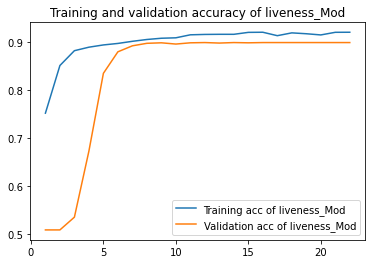

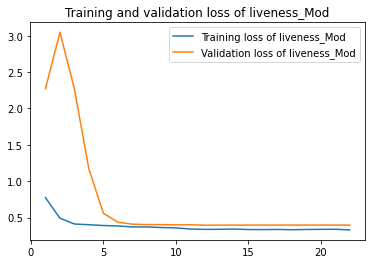

In [ ]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

In [ ]:
test_loss,test_acc = model[0].evaluate(x_test, y_test)

75/75 [==============================] - 4s 54ms/step - loss: 0.4357 - accuracy: 0.8813


In [ ]:
#accuracy_score
print("The testing accuracy of the model - " + str(round(test_acc*100,2)) + "%")

The testing accuracy of the model - 88.13%


In [ ]:
y_pred = model[0].predict(x_test)

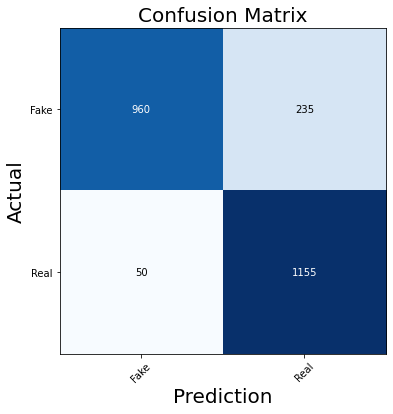

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

labels= ['Fake', 'Real']
cf = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf,class_names=labels, figsize=(9, 6))
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
print(classification_report(y_test.argmax(axis = 1),y_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1195
           1       0.83      0.96      0.89      1205

    accuracy                           0.88      2400
   macro avg       0.89      0.88      0.88      2400
weighted avg       0.89      0.88      0.88      2400



## MobileNet

In [12]:
import cv2 as cv
samples  = x_train.shape[0]
X_train = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(x_train[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_train[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [13]:
import cv2 as cv
samples  = x_val.shape[0]
X_val = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(x_val[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_val[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [14]:
import cv2 as cv
samples  = x_test.shape[0]
X_test = np.empty((samples,96,96,3),dtype = "uint8")
for i in range(samples):
    img = np.array(x_test[i], dtype=np.uint8)
    grey = cv.resize(img,(96,96))
    X_test[i] = cv.cvtColor(grey,cv.COLOR_GRAY2BGR)

In [15]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("Gender_Train:      ", np.shape(X_train), np.shape(y_train))
print("Gender_Validation: ", np.shape(X_val), np.shape(y_val))
print("Gender_Test:       ", np.shape(X_test), np.shape(y_test))

Shapes:                  Feature shape    label shape
----------------------------------------------------
Gender_Train:       (7680, 96, 96, 3) (7680, 2)
Gender_Validation:  (1920, 96, 96, 3) (1920, 2)
Gender_Test:        (2400, 96, 96, 3) (2400, 2)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense,GlobalAveragePooling2D

In [17]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D

base_model = MobileNet(include_top=False, weights='imagenet',
           input_shape=(224,224,3), classes=2)
for layer in base_model.layers:
    layer.trainable = True
tf.keras.layers.GlobalAveragePooling2D
mobilenet_model = models.Sequential()
mobilenet_model.add(layers.experimental.preprocessing.Resizing(224, 224, input_shape=(96,96,3)))
mobilenet_model.add(base_model)
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(GlobalAveragePooling2D())

#Adding the Dense Layers and Dropout
mobilenet_model.add(Dense(512,activation=('relu'))) 
mobilenet_model.add(Dense(256,activation=('relu'))) 
mobilenet_model.add(Dropout(0.3))
mobilenet_model.add(Dense(128,activation=('relu')))
mobilenet_model.add(Dropout(0.2))
mobilenet_model.add(Dense(2,activation=('softmax')))

mobilenet_model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                         

In [18]:
mobilenet_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

epochs = 50
batch_size = 64
early_stop_cb = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='auto', verbose=1),
LrValAccuracy = callbacks.ReduceLROnPlateau(factor=0.1, patience=1, monitor='val_accuracy',mode='max', verbose=1),
logs = callbacks.TensorBoard(log_dir="./log_dir/"+"MobileNet",histogram_freq=1, write_graph=True)
history = mobilenet_model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_val, y_val),
                    verbose = 1, callbacks = [early_stop_cb,LrValAccuracy,logs])

Epoch 1/50
120/120 [==============================] - 99s 694ms/step - loss: 0.6857 - accuracy: 0.5702 - val_loss: 0.7015 - val_accuracy: 0.5370 - lr: 1.0000e-04
Epoch 2/50
120/120 [==============================] - 82s 684ms/step - loss: 0.6351 - accuracy: 0.6238 - val_loss: 0.6523 - val_accuracy: 0.6016 - lr: 1.0000e-04
Epoch 3/50
120/120 [==============================] - 79s 660ms/step - loss: 0.5991 - accuracy: 0.6603 - val_loss: 0.6393 - val_accuracy: 0.6323 - lr: 1.0000e-04
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.6828
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
120/120 [==============================] - 80s 665ms/step - loss: 0.5672 - accuracy: 0.6828 - val_loss: 0.6434 - val_accuracy: 0.6240 - lr: 1.0000e-04
Epoch 5/50
120/120 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.7320
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
120/120 [==========

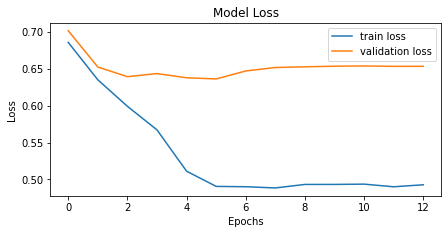

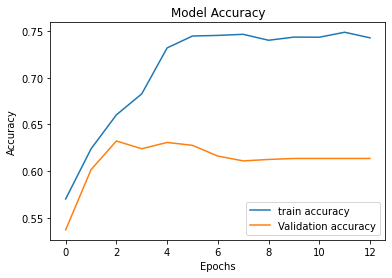

In [19]:
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'],loc='upper right')
plt.show()

fig.add_subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train accuracy','Validation accuracy'],loc='lower right')
plt.show()

In [20]:
test_loss,test_acc = mobilenet_model.evaluate(X_test, y_test)

75/75 [==============================] - 6s 72ms/step - loss: 0.6537 - accuracy: 0.6179


In [21]:
#accuracy_score
print("The testing accuracy of the model - " + str(round(test_acc*100,2)) + "%")

The testing accuracy of the model - 61.79%


In [22]:
y_pred = mobilenet_model.predict(X_test)

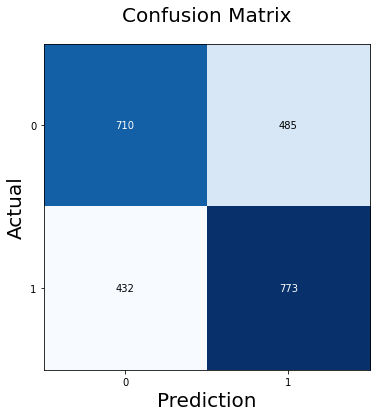

In [30]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

labels= ['Fake', 'Real']
cf1 = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
fig, ax = plot_confusion_matrix(conf_mat=cf1, figsize=(9, 6))
plt.xlabel('Prediction', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
print(classification_report(y_test.argmax(axis = 1),y_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61      1195
           1       0.61      0.64      0.63      1205

    accuracy                           0.62      2400
   macro avg       0.62      0.62      0.62      2400
weighted avg       0.62      0.62      0.62      2400

